### Clean up data and transform to correct formats

Vessel-specific data:
- Ship-type
- Draft
- Length
- Breadth
- Depth
- Engine Power
- Top speed
- longitude and latitude of destination port
- longditude and latitude of home port
- longditude and latutude of ais-port

Time-series data:
- Time since sailing
- Time untill arrival
- Mooring status (True if sog is close to zero, longitude and latitude does not change for a certain time, if the longitude and latitude are close to the known port-destinations)
- AIS data (position, cog, sog, rot, heading, ETARAW, navstat)


Ideas to derived features:
- Current speed percentage of max speed
- Historical average speed over different time frames
- Heading relative to destination port - suggests if the ship is taking a detour or not
- Changes in heading
- Use the ship dimentions to categorize into large, medium and small ships


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from timezonefinder import TimezoneFinder
import pytz

In [3]:
ais_train_data_path = '../../Project materials/ais_train.csv'
ais_test_data_path = '../../Project materials/ais_test.csv'
ports_data_path = '../../Project materials/ports.csv'
vessels_data_path = '../../Project materials/vessels.csv'
schedules_data_path = '../../Project materials/schedules_to_may_2024.csv'



ais_data_train = pd.read_csv(ais_train_data_path, sep='|')
ais_data_test = pd.read_csv(ais_test_data_path, sep=',')
ports = pd.read_csv(ports_data_path, sep='|')
vessels = pd.read_csv(vessels_data_path, sep='|')
schedules = pd.read_csv(schedules_data_path, sep='|')

In [4]:
# unique_vessel_test = ais_data_test['vesselId'].unique()


# new_ais_data_train = ais_data_train[ais_data_train['vesselId'].isin(unique_vessel_test)]
# Assuming your dataframe is named 'df' and has a 'vesselId' column
timesteps_per_ship = ais_data_train.groupby('vesselId').size()

# Sort the counts in descending order to see which ships have the most timesteps (optional)
timesteps_per_ship = timesteps_per_ship.sort_values(ascending=True)

# Display the result
print(timesteps_per_ship)


vesselId
61e9f3cbb937134a3c4bff09       1
61e9f3adb937134a3c4bfe37      31
61e9f3c6b937134a3c4bfed5     160
61e9f42cb937134a3c4c00f9     191
61e9f45cb937134a3c4c022b     196
                            ... 
61e9f465b937134a3c4c0271    7689
61e9f465b937134a3c4c026d    7928
61e9f464b937134a3c4c025f    7958
61e9f466b937134a3c4c0273    8626
6323f2287abc89c0a9631e57    8656
Length: 688, dtype: int64


### Investigate features

In [16]:
def generate_summary(dataframe, name):
    
    missing_values = dataframe.isnull().sum()
    
    stats_summary = dataframe.describe()
    
    print(f"Dataset: {name}\n")
    print("Missing Values:")
    print(missing_values)
    print("\nStatistical Summary for Numeric Columns:")
    print(stats_summary)
    print("\n" + "-"*50 + "\n")

datasets = {
    'ais_data_train': ais_data_train,
    'ports': ports,
    'vessels': vessels,
    'schedules': schedules
}


for name, df in datasets.items():
    generate_summary(df, name)

Dataset: ais_data_train

Missing Values:
time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0
vesselId        0
portId       1615
dtype: int64

Statistical Summary for Numeric Columns:
                cog           sog           rot       heading       navstat  \
count  1.522065e+06  1.522065e+06  1.522065e+06  1.522065e+06  1.522065e+06   
mean   1.782494e+02  6.331703e+00  5.054561e-01  1.762737e+02  2.092604e+00   
std    1.076785e+02  7.539364e+00  1.760916e+01  1.070860e+02  2.411965e+00   
min    0.000000e+00  0.000000e+00 -1.270000e+02  0.000000e+00  0.000000e+00   
25%    7.820000e+01  0.000000e+00  0.000000e+00  7.500000e+01  0.000000e+00   
50%    1.838000e+02  5.000000e-01  0.000000e+00  1.800000e+02  0.000000e+00   
75%    2.690000e+02  1.410000e+01  0.000000e+00  2.650000e+02  5.000000e+00   
max    3.600000e+02  1.023000e+02  1.280000e+02  5.110000e+02  1.500000e+0

In [6]:
ais_data_train['time'] = pd.to_datetime(ais_data_train['time'])


ais_data_train['time_difference'] = ais_data_train.groupby('vesselId')['time'].diff().dt.total_seconds() / 60
ais_data_train['time_difference'] = ais_data_train['time_difference'].fillna(0)


ais_data_train['time_difference'].describe()

count    1.522065e+06
mean     7.751554e+01
std      8.822453e+02
min      0.000000e+00
25%      1.901667e+01
50%      2.063333e+01
75%      2.101667e+01
max      9.872292e+04
Name: time_difference, dtype: float64

#### Port-ID in the AIS dataset

In [14]:
port_id_counts = ais_data_train['portId'].value_counts()
port_id_missing = ais_data_train['portId'].isnull().sum()


port_ids_less_than_12 = port_id_counts[port_id_counts < 12]

# Displaying the number of unique portIds that occur less than 12 times
num_port_ids_less_than_12 = len(port_ids_less_than_12)
print(f"Number of portIds that are present in less than 12 datapoints: {num_port_ids_less_than_12}")



print("Frequency Counts for portId:\n")
print(port_id_counts)
print("\nNumber of missing values in portId:", port_id_missing)


Number of portIds that are present in less than 12 datapoints: 108
Frequency Counts for portId:

portId
61d36f9a0a1807568ff9a156    84383
61d375e793c6feb83e5eb3e2    44697
61d375f793c6feb83e5eb402    40399
61d36f970a1807568ff9a151    40342
61d375e893c6feb83e5eb3e4    34227
                            ...  
634c4de270937fc01c3a7425        1
635e9424bef885201a5e0fcc        1
634c4de270937fc01c3a71a7        1
634c4de270937fc01c3a75d9        1
634c4de270937fc01c3a713e        1
Name: count, Length: 772, dtype: int64

Number of missing values in portId: 1615


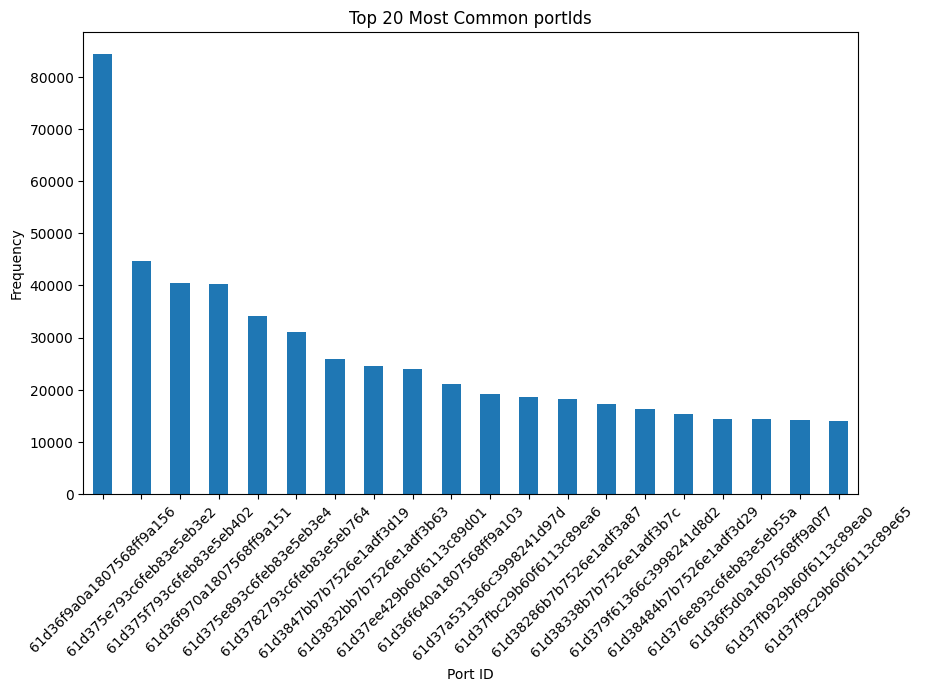

In [10]:
import matplotlib.pyplot as plt

top_port_ids = port_id_counts.head(20)
plt.figure(figsize=(10, 6))
top_port_ids.plot(kind='bar')
plt.title('Top 20 Most Common portIds')
plt.xlabel('Port ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

##### Conclutions

- The port-id can be useful, but it should be used with caution beacuse of the inconsistencies mentioned in the dataset-definitions, its missing values and its large-count low frequency ports 
- Should try to infer the most likely destination port based on historically visited ports, heading and the most reacent port-id in the AIS dataset. 
- Based on this the vessels distance to its most likely destination port can be calculated
- Evaluate the performance of this 

In [9]:
ship_train_groups = ais_data_train.groupby('vesselId')
ship_train_dataframes = {ship_id: group for ship_id, group in ship_train_groups}

In [81]:
DISTANCE_THRESHOLD_KM = 5.0

# Function to infer visited ports for a given vessel dataframe based on latitude and longitude
def infer_visited_ports(vessel_df, ports_df, distance_threshold):
    visited_ports = set()
    
    for index, row in vessel_df.iterrows():
        vessel_position = (row['latitude'], row['longitude'])
        
        for _, port_row in ports_df.iterrows():
            port_position = (port_row['latitude'], port_row['longitude'])
            
            distance = geodesic(vessel_position, port_position).km
            
            if distance <= distance_threshold:
                visited_ports.add(port_row['portId'])
    
    return list(visited_ports)

vessel_visited_ports = {}

# Loop through each vessel dataframe and infer the visited ports
for vessel_id, vessel_df in ship_train_dataframes.items():
    visited_ports = infer_visited_ports(vessel_df, ports, DISTANCE_THRESHOLD_KM)
    vessel_visited_ports[vessel_id] = visited_ports
    print('vessel done')
    print(len(vessel_visited_ports[vessel_id]))

# Display the visited ports for each vessel
for vessel_id, ports in vessel_visited_ports.items():
    print(f"Vessel ID: {vessel_id} visited ports: {ports}")


KeyboardInterrupt: 

#### ETARAW in the ais dataset

In [13]:
current_year = 2024
ais_data_train['ETARAW_transformed'] = ais_data_train['etaRaw'].apply(lambda x: f"{current_year}-{x}")

# Converting to datetime format
ais_data_train['ETARAW_transformed'] = pd.to_datetime(ais_data_train['ETARAW_transformed'], format='%Y-%m-%d %H:%M', errors='coerce')
print(ais_data_train['ETARAW_transformed'].dtypes)
print(ais_data_train[['etaRaw', 'ETARAW_transformed']].head())

# Count the number of NaT values
num_nat_values = ais_data_train['ETARAW_transformed'].isna().sum()
print(f"Number of NaT (unconverted) values: {num_nat_values}")



datetime64[ns]
        etaRaw  ETARAW_transformed
0  01-09 23:00 2024-01-09 23:00:00
1  12-29 20:00 2024-12-29 20:00:00
2  01-02 09:00 2024-01-02 09:00:00
3  12-31 20:00 2024-12-31 20:00:00
4  01-25 12:00 2024-01-25 12:00:00
Number of NaT (unconverted) values: 3763


In [34]:
# Extract rows where ETARAW_transformed could not be converted
unconverted_rows = ais_data_train[ais_data_train['ETARAW_transformed'].isna()]

# Display the first few rows to inspect
print(unconverted_rows[['etaRaw', 'ETARAW_transformed']].head())


            etaRaw ETARAW_transformed
32785  00-00 23:00                NaT
32895  00-00 23:00                NaT
33093  00-00 23:00                NaT
33162  00-00 23:00                NaT
33615  00-00 23:00                NaT


In [6]:
ais_data_train['time'] = pd.to_datetime(ais_data_train['time'], errors='coerce')

# Filter rows with valid ETARAW_transformed and compare with the corresponding 'time' value
invalid_eta_condition = ais_data_train['ETARAW_transformed'].notna() & (ais_data_train['ETARAW_transformed'] < ais_data_train['time'])

# Extract rows where ETARAW is before the corresponding timestamp
outdated_eta_df = ais_data_train[invalid_eta_condition]

# Filter rows from outdated ETARAW where SOG is approximately 0 (e.g., less than or equal to 0.5 knots)
sog_stationary_condition = outdated_eta_df['sog'] <= 0.5
stationary_outdated_eta_df = outdated_eta_df[sog_stationary_condition]

# Calculate the proportion
num_outdated_eta = len(outdated_eta_df)
num_stationary_outdated_eta = len(stationary_outdated_eta_df)
proportion_stationary = num_stationary_outdated_eta / num_outdated_eta if num_outdated_eta > 0 else 0

# Display the results
print(f"Total number of outdated ETARAW values: {num_outdated_eta}")
print(f"Number of outdated ETARAW values with SOG approximately 0: {num_stationary_outdated_eta}")
print(f"Proportion of outdated ETARAW values with SOG approximately 0: {proportion_stationary:.2f}")


Total number of outdated ETARAW values: 746580
Number of outdated ETARAW values with SOG approximately 0: 592559
Proportion of outdated ETARAW values with SOG approximately 0: 0.79


In [49]:
# Assuming ais_data_train is already loaded and ETARAW_transformed is created

# Filter rows where NAVSTAT indicates the vessel is "Moored" (5) or "At Anchor" (1)
moored_or_anchor_condition = ais_data_train['navstat'].isin([5, 1])
moored_or_anchor_df = ais_data_train[moored_or_anchor_condition]

# Filter rows from moored_or_anchor_df where ETARAW is outdated (i.e., before the timestamp)
outdated_eta_condition = moored_or_anchor_df['ETARAW_transformed'].notna() & (moored_or_anchor_df['ETARAW_transformed'] < moored_or_anchor_df['time'])
outdated_eta_moored_or_anchor_df = moored_or_anchor_df[outdated_eta_condition]
outdated_eta_moored_or_anchor_sog_nill_df = outdated_eta_moored_or_anchor_df[sog_stationary_condition]

# Calculate the proportion of moored/anchored rows where ETARAW is outdated
num_moored_or_anchor = len(moored_or_anchor_df)
num_outdated_eta_moored_or_anchor = len(outdated_eta_moored_or_anchor_df)
num_outdated_eta_moored_or_anchor_sog_nill = len(outdated_eta_moored_or_anchor_sog_nill_df)
proportion_outdated_eta = num_outdated_eta_moored_or_anchor / num_moored_or_anchor if num_moored_or_anchor > 0 else 0
proportion_outdated_eta_sog = num_outdated_eta_moored_or_anchor_sog_nill/num_moored_or_anchor

# Display the results
print(f"Total number of datapoints with NAVSTAT as 'Moored' (5) or 'At Anchor' (1): {num_moored_or_anchor}")
print(f"Number of datapoints with NAVSTAT as 'Moored' or 'At Anchor' and outdated ETARAW: {num_outdated_eta_moored_or_anchor}")
print(f"Proportion of moored/anchored datapoints with outdated ETARAW: {proportion_outdated_eta:.2f}")
print(f"Proportion of moored/anchored datapoints with outdated ETARAW and sog close to zero: {proportion_outdated_eta:.2f}")


Total number of datapoints with NAVSTAT as 'Moored' (5) or 'At Anchor' (1): 735346
Number of datapoints with NAVSTAT as 'Moored' or 'At Anchor' and outdated ETARAW: 571403
Proportion of moored/anchored datapoints with outdated ETARAW: 0.78
Proportion of moored/anchored datapoints with outdated ETARAW and sog close to zero: 0.78


C:\Users\marku\AppData\Local\Temp\ipykernel_25512\1099545497.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outdated_eta_moored_or_anchor_sog_nill_df = outdated_eta_moored_or_anchor_df[sog_stationary_condition]


In [42]:


# Assuming ais_data_train is already loaded
def is_invalid_eta(etaraw):
    return etaraw.startswith('00-00')

# Add a column indicating whether ETARAW is invalid
ais_data_train['invalid_eta'] = ais_data_train['etaRaw'].apply(lambda x: is_invalid_eta(x) if pd.notna(x) else False)

# Sort the dataframe by vessel ID and timestamp to ensure correct ordering
ais_data_train = ais_data_train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

# Dictionary to store consecutive invalid counts for each vessel
consecutive_invalid_summary = {}

# Iterate through each vessel group to calculate consecutive invalid ETARAW values
for vessel_id, group in ais_data_train.groupby('vesselId'):
    consecutive_count = 0
    max_consecutive_count = 0
    
    # Iterate through the rows for each vessel to calculate consecutive invalid counts
    for is_invalid in group['invalid_eta']:
        if is_invalid:
            consecutive_count += 1
        else:
            if consecutive_count > 0:
                max_consecutive_count = max(max_consecutive_count, consecutive_count)
            consecutive_count = 0

    # Capture the last streak if it ended at the end of the group
    max_consecutive_count = max(max_consecutive_count, consecutive_count)
    
    # Store the result for this vessel
    consecutive_invalid_summary[vessel_id] = max_consecutive_count

# Convert the summary to a DataFrame for better display
consecutive_invalid_df = pd.DataFrame(list(consecutive_invalid_summary.items()), columns=['vesselId', 'max_consecutive_invalid_etaraw'])

# Filter the summary dataframe to only include vessels with at least one consecutive invalid ETARAW value
vessels_with_invalid_eta = consecutive_invalid_df[consecutive_invalid_df['max_consecutive_invalid_etaraw'] > 0]

# Display the overview of vessels with at least one consecutive invalid ETARAW value
print(vessels_with_invalid_eta.head(94))

                     vesselId  max_consecutive_invalid_etaraw
1    61e9f38eb937134a3c4bfd8d                               8
16   61e9f396b937134a3c4bfdad                              12
20   61e9f399b937134a3c4bfdb5                              71
26   61e9f39cb937134a3c4bfdc1                              36
32   61e9f39fb937134a3c4bfdcd                              13
..                        ...                             ...
634  61e9f47bb937134a3c4c02fd                              73
637  62080cff66fc0a8e43c6123a                              14
654  631e3eb0192150e13fa41628                               5
670  6326f449c46d6a20d22ca31d                              42
675  6326fcf5c46d6a20d22ca323                               5

[94 rows x 2 columns]


In [11]:


# Assuming vessel_data_dict is the dictionary with vesselId as keys and dataframes as values
# Each dataframe contains AIS data with columns like 'time' and 'etaRaw'

def compute_time_difference_with_interpolation(vessel_data_dict):
    for vessel_id, df in vessel_data_dict.items():
        # Sort the dataframe by time for each vessel to ensure interpolation is done in a chronological order
        df = df.sort_values(by='time')

        # Convert 'etaRaw' and 'time' to datetime format
        df['etaRaw'] = pd.to_datetime(df['etaRaw'], errors='coerce')
        df['time'] = pd.to_datetime(df['time'], errors='coerce')

        # Set 'time' as the index to allow for time-based interpolation
        df = df.set_index('time')

        # Interpolate 'etaRaw' linearly for NaN values based on time
        df['etaRaw'] = df['etaRaw'].interpolate(method='time')

        # Reset the index back to a column
        df = df.reset_index()

        # Calculate the time difference between 'etaRaw' and 'time' in hours
        df['time_difference'] = (df['etaRaw'] - df['time']).dt.total_seconds() / 3600

        # Update the dictionary with the modified dataframe
        vessel_data_dict[vessel_id] = df

    return vessel_data_dict

# Example usage
# vessel_data_dict = { ... }  # Dictionary of ship-ids as keys and corresponding dataframes
vessel_data_dict = compute_time_difference_with_interpolation(ship_train_dataframes)

# Display the first few rows of each vessel's dataframe to verify the result
for vessel_id, df in vessel_data_dict.items():
    print(f"Vessel ID: {vessel_id}")
    print(df.head())
    break  # Just display the first vessel's data for brevity



C:\Users\marku\AppData\Local\Temp\ipykernel_18576\3771935248.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['etaRaw'] = pd.to_datetime(df['etaRaw'], errors='coerce')


ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got time

##### Conclutions

- 94 of the ships contain invalid etaRaw values -> often corresponds to the ships mooring-status
- Almost 750 000 of the timestamps have eta values before the time of the timestamp, almost 80% of these has a corresponding speed over ground close to 0 and navigational status as moored or at anchor

#### Navigation status

Interpretation of values:
- 0: underway using engine
- 1: At anchor
- 2: Not under command
- 3: Restricted menouverability
- 4: Constrained by her draught
- 5: moored
- 6: aground
- 7: engaged in fishing
- 8: under way sailing
- 9-13: Reserved for future use
- 14: AIS-SART is active
- 15: default (not defined)

In [46]:
navstat_frequency = ais_data_train['navstat'].value_counts()

# Display the frequency of each NAVSTAT value
print("Frequency of each NAVSTAT value:")
print(navstat_frequency)


Frequency of each NAVSTAT value:
navstat
0     782099
5     605831
1     129515
2       2081
8        948
15       670
6        521
4        232
3        161
11         2
13         1
14         1
7          1
12         1
9          1
Name: count, dtype: int64


In [7]:
def categorize_navstat_contrast(navstat):
    if navstat in [0, 8]:
        return 1  # Underway
    elif navstat in [2, 3, 4]:
        return 0.5  # Restricted Movement
    elif navstat in [1, 5, 6]:
        return -1  # Stationary
    else:
        return 0  # Unknown

# Apply the function to create a new column for the grouped NAVSTAT
ais_data_train['movement_status'] = ais_data_train['navstat'].apply(categorize_navstat_contrast)

# Display the frequency of each numeric movement status with contrast
movement_status_contrast_frequency = ais_data_train['movement_status'].value_counts()
print("Frequency of each numeric movement status with contrast:")
print(movement_status_contrast_frequency)

Frequency of each numeric movement status with contrast:
movement_status
 1.0    783047
-1.0    735867
 0.5      2474
 0.0       677
Name: count, dtype: int64


#### Conclutions

- Navigation status can definately provide good representations of the vessels movement status
- These have been combined into four new features : 1: Underway (0 and 8), 0.5: Restricted movement (2, 3, 4), -1: stationary (1, 5, 6) and 0: unknown (7, 9 - 15)

### Investigating how to use schedules to mai 2024

Interesting points
- The time of schedules have timezone information, the ais-time does not. Can infer this by using the latitude and longitude of the given timestamp and then use the time to lookup in the schedules file
- "Vessels follows shipping routes similarly as busses" -> historic schedules are very interesting to inspect
- There are 4000 ish schedules without a port-id -> Suggestion: Remove these columns
- All visited ports for a vessels given schedules can be gathered in a list and then based on the previous port that ship was in and heading of the ship used to infer the most likely next port?




Plan
- Discuss with chat how to infer the most likely next port
- Figure out how to lookup on the correct scheule for the given ship and examine if there are any ships in the test-dataset that does not have a corresponding schedule
- 

In [55]:
# Check the timezone information for each datetime column

# AIS data 'time' column
print("AIS 'time' column timezone information:")
print(ais_data_train['time'].dtype)  # Check dtype
print(ais_data_train['time'].dt.tz)  # Check if tz-aware or tz-naive

# Schedule 'sailingDate' column
print("\nSchedule 'sailingDate' column timezone information:")
print(schedules['sailingDate'].dtype)  # Check dtype
print(schedules['sailingDate'].dt.tz)  # Check if tz-aware or tz-naive

# Schedule 'arrivalDate' column
print("\nSchedule 'arrivalDate' column timezone information:")
print(schedules['arrivalDate'].dtype)  # Check dtype
print(schedules['arrivalDate'].dt.tz)  # Check if tz-aware or tz-naive


AIS 'time' column timezone information:
datetime64[ns]
None

Schedule 'sailingDate' column timezone information:
datetime64[ns, UTC]
UTC

Schedule 'arrivalDate' column timezone information:
datetime64[ns, UTC]
UTC


In [86]:
schedules_cleaned = schedules.dropna(subset=['vesselId'])
schedules_cleaned = schedules_cleaned.dropna(subset=['portId'])

schedules = schedules_cleaned

# Check how many schedules have NaN values in the 'portId' column
nan_port_id_count = schedules_cleaned.isna().sum()

# Display the count of schedules with NaN values for 'portId'
print(f"Number of schedules with NaN values in 'portId': {nan_port_id_count}")


Number of schedules with NaN values in 'portId': vesselId               0
shippingLineId         0
shippingLineName       0
arrivalDate         4590
sailingDate         1627
portName               0
portId                 0
portLatitude           0
portLongitude          0
dtype: int64


In [87]:


# Assuming schedules_to_may dataframe is already loaded and contains a 'vesselId' column

# Group by 'vesselId' to count the number of schedules for each vessel
schedules_count_per_vessel = schedules.groupby('vesselId').size().reset_index(name='schedule_count')

# Display the first few rows of the result to see how many schedules each vessel has
print(schedules_count_per_vessel.head())

# Optionally, display summary statistics of schedule counts
print("\nSummary of schedules per vessel:")
print(schedules_count_per_vessel['schedule_count'].describe())


                   vesselId  schedule_count
0  61e9f38eb937134a3c4bfd8b             760
1  61e9f38eb937134a3c4bfd8f              15
2  61e9f390b937134a3c4bfd93             106
3  61e9f391b937134a3c4bfd95              99
4  61e9f391b937134a3c4bfd97             247

Summary of schedules per vessel:
count     251.000000
mean      508.107570
std       499.892293
min         1.000000
25%        84.000000
50%       319.000000
75%       826.000000
max      1988.000000
Name: schedule_count, dtype: float64


In [88]:
schedules_count_per_vessel_port = schedules.groupby(['vesselId', 'portId']).size().reset_index(name='schedule_count')

# Display the first few rows to see how many schedules each vessel has for the same port
print(schedules_count_per_vessel_port.head())

# Summary statistics of schedules per vessel-port combination
print("\nSummary of schedules per vessel-port combination:")
print(schedules_count_per_vessel_port['schedule_count'].describe())

                   vesselId                    portId  schedule_count
0  61e9f38eb937134a3c4bfd8b  61d36f970a1807568ff9a151              36
1  61e9f38eb937134a3c4bfd8b  61d36f9a0a1807568ff9a156              26
2  61e9f38eb937134a3c4bfd8b  61d372143aeaecc07011a403               8
3  61e9f38eb937134a3c4bfd8b  61d373443aeaecc07011a58f               1
4  61e9f38eb937134a3c4bfd8b  61d374543aeaecc07011a722              43

Summary of schedules per vessel-port combination:
count    4747.000000
mean       26.866442
std        37.334101
min         1.000000
25%         3.000000
50%        14.000000
75%        34.000000
max       361.000000
Name: schedule_count, dtype: float64


In [89]:

# Assuming schedules dataframe is already loaded and contains 'vesselId' and 'portId' columns

# Group by 'vesselId' to count the number of unique ports each vessel is scheduled to visit
unique_ports_per_vessel = schedules.groupby('vesselId')['portId'].nunique().reset_index(name='unique_port_count')

# Display the first few rows of the result to see how many unique ports each vessel is scheduled to visit
print(unique_ports_per_vessel.head())

# Summary statistics of unique port counts per vessel
print("\nSummary of unique ports per vessel:")
print(unique_ports_per_vessel['unique_port_count'].describe())


                   vesselId  unique_port_count
0  61e9f38eb937134a3c4bfd8b                 51
1  61e9f38eb937134a3c4bfd8f                 11
2  61e9f390b937134a3c4bfd93                 13
3  61e9f391b937134a3c4bfd95                 11
4  61e9f391b937134a3c4bfd97                  7

Summary of unique ports per vessel:
count    251.000000
mean      18.912351
std       12.028312
min        1.000000
25%        9.000000
50%       16.000000
75%       28.500000
max       51.000000
Name: unique_port_count, dtype: float64


In [93]:


# Assuming schedules dataframe is already loaded and contains 'vesselId' and 'portId' columns

# Filter schedules to only include those with a valid 'portId'
valid_port_schedules = schedules[schedules['portId'].notna()]

# Group by 'vesselId' to count the number of schedules with valid 'portId' for each vessel
valid_schedules_count_per_vessel = valid_port_schedules.groupby('vesselId').size().reset_index(name='valid_schedule_count')

# Filter vessels that have less than 5 schedules with valid 'portId'
vessels_less_than_five_valid = valid_schedules_count_per_vessel[valid_schedules_count_per_vessel['valid_schedule_count'] < 5]

# Display the first few rows to see which vessels have less than 5 valid schedules
print(vessels_less_than_five_valid.head())

# Display the total number of vessels with less than 5 valid schedules
print(f"\nNumber of vessels with less than 5 valid schedules: {len(vessels_less_than_five_valid)}")


                     vesselId  valid_schedule_count
103  61e9f3bfb937134a3c4bfe9f                     4
108  61e9f3dcb937134a3c4bff3f                     4
146  61e9f3fdb937134a3c4bffdf                     2
179  61e9f415b937134a3c4c0061                     3
204  61e9f424b937134a3c4c00cd                     4

Number of vessels with less than 5 valid schedules: 12


In [78]:


# Assuming schedules and ais_test dataframes are already loaded

# Step 1: Get unique vessel IDs from AIS test dataset
unique_vessel_ids_test = ais_data_test['vesselId'].unique()

# Step 2: Filter schedules to only include those with a valid 'portId' and belonging to vessels in the AIS test set
valid_schedules_for_test_vessels = schedules[(schedules['portId'].notna()) & (schedules['vesselId'].isin(unique_vessel_ids_test))]

# Step 3: Group by 'vesselId' to count the number of valid schedules for each vessel
valid_schedules_count_per_vessel_test = valid_schedules_for_test_vessels.groupby('vesselId').size().reset_index(name='valid_schedule_count')

# Step 4: Filter vessels that have less than 5 valid schedules
vessels_less_than_five_valid_test = valid_schedules_count_per_vessel_test[valid_schedules_count_per_vessel_test['valid_schedule_count'] < 5]

# Step 5: Get the total count of vessels with fewer than 5 valid schedules
vessels_less_than_five_valid_test_count = len(vessels_less_than_five_valid_test)

# Display the result
print(f"Number of vessels in AIS test dataset with less than 5 valid schedules: {vessels_less_than_five_valid_test_count}")

# Optionally, display the first few rows of vessels with less than 5 valid schedules
print("\nVessels with less than 5 valid schedules:")
print(vessels_less_than_five_valid_test.head(6))


Number of vessels in AIS test dataset with less than 5 valid schedules: 6

Vessels with less than 5 valid schedules:
                    vesselId  valid_schedule_count
54  61e9f424b937134a3c4c00cd                     4
56  61e9f429b937134a3c4c00e7                     1
57  61e9f42ab937134a3c4c00e9                     3
60  61e9f438b937134a3c4c0149                     4
61  61e9f443b937134a3c4c0197                     3
63  61e9f45fb937134a3c4c0239                     4


In [96]:


# Assuming schedules dataframe is already loaded
# Group by 'vesselId' and 'portId' to determine the most frequent next port for each vessel and current port
schedules['sailingDate'] = pd.to_datetime(schedules['sailingDate'])
schedules_sorted = schedules.sort_values(by=['vesselId', 'sailingDate'])
schedules['next_port'] = schedules_sorted.groupby('vesselId')['portId'].shift(-1)
route_frequency = schedules.groupby(['vesselId', 'portId', 'next_port']).size().reset_index(name='route_count')

# Get the most likely next port for each vessel-port combination
most_likely_next_port = route_frequency.loc[route_frequency.groupby(['vesselId', 'portId'])['route_count'].idxmax()]


print(most_likely_next_port.head())


                    vesselId                    portId  \
0   61e9f38eb937134a3c4bfd8b  61d36f970a1807568ff9a151   
5   61e9f38eb937134a3c4bfd8b  61d36f9a0a1807568ff9a156   
8   61e9f38eb937134a3c4bfd8b  61d372143aeaecc07011a403   
10  61e9f38eb937134a3c4bfd8b  61d373443aeaecc07011a58f   
12  61e9f38eb937134a3c4bfd8b  61d374543aeaecc07011a722   

                   next_port  route_count  
0   61d36f970a1807568ff9a151           28  
5   61d36f9a0a1807568ff9a156           20  
8   61d372143aeaecc07011a403            7  
10  61d3784c93c6feb83e5eb7a2            1  
12  61d374543aeaecc07011a722           31  


In [8]:

ship_train_groups = ais_data_train.groupby('vesselId')
ship_train_dataframes = {ship_id: group for ship_id, group in ship_train_groups}

In [11]:


# Assuming 'vessel_data_dict' is a dictionary with vesselId as keys and each value being a dataframe with AIS data
# 'ports' dataframe contains columns 'portId', 'portLatitude', 'portLongitude'

# Function to find the last visited port for each vessel
def find_last_visited_port(vessel_data_dict, ports):
    last_visited_ports = {}

    # Iterate through each vessel in the dictionary
    for vessel_id, vessel_data in vessel_data_dict.items():
        # Sort the vessel data by 'time' in descending order to iterate backward in time
        vessel_data = vessel_data.sort_values(by='time', ascending=False)

        # Iterate through each timestep in the vessel data
        for _, row in vessel_data.iterrows():
            if row['movement_status_contrast'] == -1:  # Check if movement status contrast is -1
                # Get the vessel's current latitude and longitude
                vessel_coords = (row['latitude'], row['longitude'])
                
                # Iterate through each port to check if the vessel's location matches the port's location
                for _, port_row in ports.iterrows():
                    port_coords = (port_row['latitude'], port_row['longitude'])
                    
                    # Check if the vessel is close to the port (using a threshold distance, e.g., within 1 km)
                    if geodesic(vessel_coords, port_coords).km < 1:
                        # If a match is found, save the portId as the last visited port for this vessel
                        last_visited_ports[vessel_id] = port_row['portId']
                        print("Port found")
                        break  # Break the inner loop if a match is found
            
            # If the last visited port is found, break the outer loop for this vessel
            if vessel_id in last_visited_ports:
                break

    return last_visited_ports

# Example usage
# Assuming 'vessel_data_dict' and 'ports' dataframes are already loaded
last_visited_ports = find_last_visited_port(ship_train_dataframes, ports)

# Display the results
for vessel_id, port_id in last_visited_ports.items():
    print(f"Vessel {vessel_id} last visited port: {port_id}")


Port found


KeyboardInterrupt: 

In [4]:


# Assuming ais_data_train and schedules are dataframes already loaded
# Initialize the TimezoneFinder
tf = TimezoneFinder()

# Function to find timezone based on latitude and longitude
def find_timezone(lat, lon):
    try:
        return tf.timezone_at(lat=lat, lng=lon)
    except:
        return None

# Function to convert UTC time to local time using the found timezone
def convert_to_local_time(time, timezone_name):
    if pd.notna(timezone_name):
        local_timezone = pytz.timezone(timezone_name)
        return time.astimezone(local_timezone)
    else:
        print("Error")
        return None  # If timezone is not found, keep the time as is

# Convert 'time' column to datetime and localize it to UTC
ais_data_train['time'] = pd.to_datetime(ais_data_train['time']).dt.tz_localize('UTC')

# Apply timezone finder to get the correct timezone for each AIS record
ais_data_train['timezone'] = ais_data_train.apply(lambda row: find_timezone(row['latitude'], row['longitude']), axis=1)

# Convert AIS time from UTC to local time for each record based on the found timezone
ais_data_train['time'] = ais_data_train.apply(lambda row: convert_to_local_time(row['time'], row['timezone']), axis=1)

# Drop the temporary 'timezone' column as it is no longer needed
ais_data_train = ais_data_train.drop(columns=['timezone'])

# Display the first few rows to verify the updated time column
print(ais_data_train.head())
